In [3]:
!pip install pyspark
!pip install findspark
!pip install spark-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=f479e17628cf6310c19c2730c32d166ba412c5508acafe0fc89a063cf177d9e2
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.4/568.4 kB 17.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Bidirectional,
    LSTM,
    Dense,
    Dropout,
    Concatenate,
)
import sparknlp
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from pyspark.sql.functions import col, mean, stddev
from pyspark.ml.feature import StopWordsRemover
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split,explode
from pyspark.sql.functions import col , sum as sum_func , when ,mean as _mean, stddev as _stddev, col , collect_list
from pyspark.sql.types import StringType, ArrayType, FloatType, StructType, StructField


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU(s) available:")
    for gpu in gpus:
        print(gpu)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    tf.config.set_visible_devices(gpus[0], 'GPU')  # Use the first GPU
else:
    print("No GPU available, using CPU instead.")


GPU(s) available:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
spark = sparknlp.start(gpu=True)

data = spark.read.csv(
    "/kaggle/input/genres-cleaned/cleaned_songs.csv", header=True, inferSchema=True
)

features = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
]

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp-gpu_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-bc979cce-5233-4b85-b41e-10c6c1611313;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp-gpu_2.12;5.3.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in central
	fou

In [7]:
def extract_columns(data, column_names):
    """Extract specific columns from a DataFrame."""
    return data.select(column_names)

def normalize_features(df, features):
    """Normalize the features in the DataFrame."""
    for feature in features:
        # Calculate mean and standard deviation
        stats = df.select(
            _mean(col(feature)).alias("mean"),
            _stddev(col(feature)).alias("stddev")
        ).collect()
        mean = stats[0]["mean"]
        stddev = stats[0]["stddev"]

        # Z-score normalization
        df = df.withColumn(feature + "_zscore", (col(feature) - mean) / stddev)

        # Find the maximum absolute value after z-score normalization
        max_abs_value = df.selectExpr(f"max(abs({feature}_zscore)) as max_abs_value").collect()[0]["max_abs_value"]

        # Scale the z-score normalized feature to lie between -1 and 1 and replace the original feature
        df = df.withColumn(feature, col(feature + "_zscore") / max_abs_value)

        # Drop the intermediate z-score normalized column
        df = df.drop(feature + "_zscore")
    
    return df

def get_unique_genres(labels):
    """Get the number of unique genres and the list of unique genres."""
    num_classes = labels.select("playlist_genre").distinct().count()
    unique_genres = labels.select("playlist_genre").distinct().collect()
    return num_classes, unique_genres



In [8]:
df = normalize_features(data,features)
df.show(2)
cleaned_data = df

+-----------------+--------------+--------------------+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------+--------------------+
|playlist_subgenre|playlist_genre|            track_id|       danceability|              energy|                key|            loudness|              mode|         speechiness|        acousticness|    instrumentalness|            liveness|            valence|               tempo|        duration_ms|language|              lyrics|
+-----------------+--------------+--------------------+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------+--------------------+
|   

In [9]:
labels = data.select("playlist_genre")
num_classes, unique_genres = get_unique_genres(labels)

In [10]:
print('Number of audio features:', len(features))
print('Features:', features)
print('Number of genres:', num_classes)
print('Genres:', [row.playlist_genre for row in unique_genres])

Number of audio features: 12
Features: ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Number of genres: 6
Genres: ['r&b', 'pop', 'edm', 'rap', 'rock', 'latin']


In [11]:

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(cleaned_data.select("playlist_genre").rdd.map(lambda x: x[0]).collect())

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
cleaned_data.select(features).toPandas() , y_encoded, test_size=0.2, random_state=42
)


In [13]:
print(y_encoded[:5])

[5 3 3 2 3]


In [14]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=6)
y_val_encoded = to_categorical(y_val, num_classes=6)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ audio_features_input            │ (None, 12)             │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,310 (40.27 KB)

 Trainable params: 10,310 (40.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
 92/439 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2647 - loss: 1.7309

I0000 00:00:1715538612.522941    1023 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3589 - loss: 1.5776 - val_accuracy: 0.4855 - val_loss: 1.3205
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4921 - loss: 1.3149 - val_accuracy: 0.5003 - val_loss: 1.2902
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5032 - loss: 1.2853 - val_accuracy: 0.5145 - val_loss: 1.2697
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5078 - loss: 1.2610 - val_accuracy: 0.5205 - val_loss: 1.2490
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5283 - loss: 1.2362 - val_accuracy: 0.5251 - val_loss: 1.2420
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5291 - loss: 1.2331 - val_accuracy: 0.5331 - val_loss: 1.2336
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5284 - loss: 1.2335 - val_accuracy: 0.5328 - val_loss: 1.2330
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5353 - loss: 1.2133 - val_accuracy: 0.5322 - val_

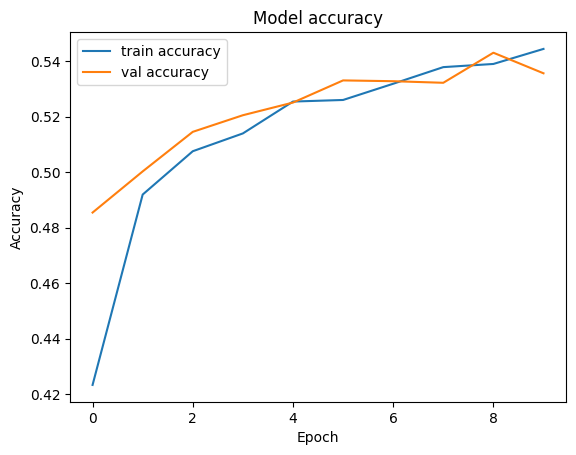

In [15]:
audio_input = Input(
    shape=(len(features),), dtype="float32", name="audio_features_input"
)

dense_layer = Dense(128, activation="relu")(audio_input)
dense_layer = Dense(64, activation='relu')(dense_layer)
output_layer = Dense(num_classes, activation='softmax')(dense_layer)

model = Model(inputs=audio_input, outputs=output_layer)

model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)  

model.summary()

history = model.fit(
   X_train , y_train_encoded, 
    validation_data=(X_val, y_val_encoded), 
    epochs=10, 
    batch_size=32
)
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(len(features),)),  # Input layer with input shape (4,)
    tf.keras.layers.Dense(6, activation='softmax')  # Output layer with 3 units (3 classes) and softmax activation
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train_encoded,epochs=50, batch_size=8)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2479 - loss: 1.7286
Epoch 2/50
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4002 - loss: 1.5285
Epoch 3/50
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4414 - loss: 1.4549
Epoch 4/50
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4625 - loss: 1.4135
Epoch 5/50
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4584 - loss: 1.4096
Epoch 6/50
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4751 - loss: 1.3782
Epoch 7/50
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4672 - loss: 1.3785
Epoch 8/50
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4737 - loss: 1.3671
Epoch 9/50
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4704 - loss: 1.3642
Epoch 10/50
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4697 - loss: 1.3663
Epoch 11/50
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4678 - loss: 1.3703
Epoch 12/50
1754/1754 ━━━━━━━━━━━━━━━━━━━

In [26]:
y_pred = model.predict(X_val)
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Get classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.49
              precision    recall  f1-score   support

           0       0.50      0.37      0.43       383
           1       0.45      0.17      0.25       421
           2       0.39      0.49      0.43       783
           3       0.47      0.43      0.45       637
           4       0.56      0.64      0.60       635
           5       0.56      0.66      0.61       649

    accuracy                           0.49      3508
   macro avg       0.49      0.46      0.46      3508
weighted avg       0.49      0.49      0.47      3508



In [17]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score
y_pred_prob = model.predict(X_val)
auc_score = roc_auc_score(y_val_encoded, y_pred_prob)

print("AUC Score:", auc_score)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC Score: 0.5656226899877201


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy for edm: 0.37
Accuracy for latin: 0.17
Accuracy for pop: 0.50
Accuracy for r&b: 0.44
Accuracy for rap: 0.64
Accuracy for rock: 0.64
              precision    recall  f1-score   support

         edm       0.50      0.37      0.43       383
       latin       0.45      0.17      0.24       421
         pop       0.38      0.50      0.44       783
         r&b       0.47      0.44      0.46       637
         rap       0.57      0.64      0.60       635
        rock       0.57      0.64      0.60       649

    accuracy                           0.49      3508
   macro avg       0.49      0.46      0.46      3508
weighted avg       0.49      0.49      0.48      3508



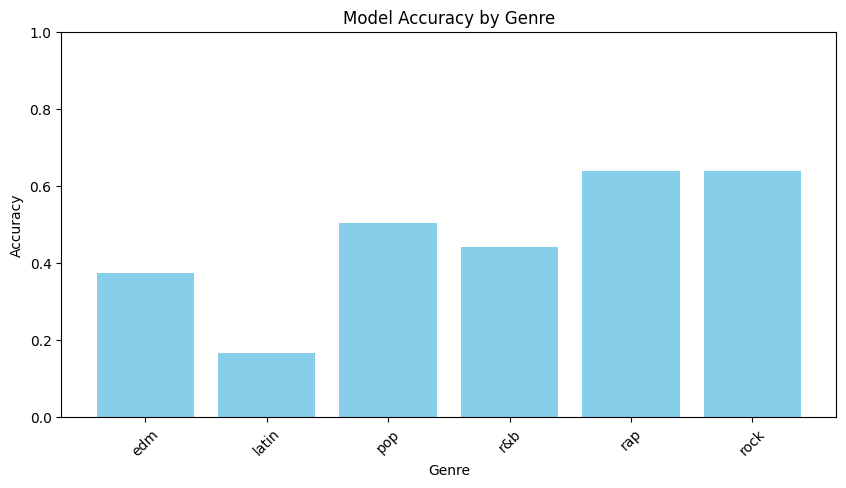

In [44]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
# Make predictions
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to label indices

# Inverse transform labels
y_true_labels = label_encoder.inverse_transform(y_val)
y_pred_labels = label_encoder.inverse_transform(y_pred_labels)

# Calculate accuracy per genre
unique_genres = np.unique(y_true_labels)
genre_accuracy = {}

for genre in unique_genres:
    genre_mask = (y_true_labels == genre)
    genre_accuracy[genre] = accuracy_score(y_true_labels[genre_mask], y_pred_labels[genre_mask])

# Display the accuracy for each genre
for genre, accuracy in genre_accuracy.items():
    print(f"Accuracy for {genre}: {accuracy:.2f}")

print(classification_report(y_true_labels, y_pred_labels)) 
# Plotting the accuracy for each genre
genres = list(genre_accuracy.keys())
accuracies = [genre_accuracy[genre] for genre in genres]

plt.figure(figsize=(10, 5))
plt.bar(genres, accuracies, color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Genre')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Set y-axis limits to show accuracy from 0 to 1
plt.show()

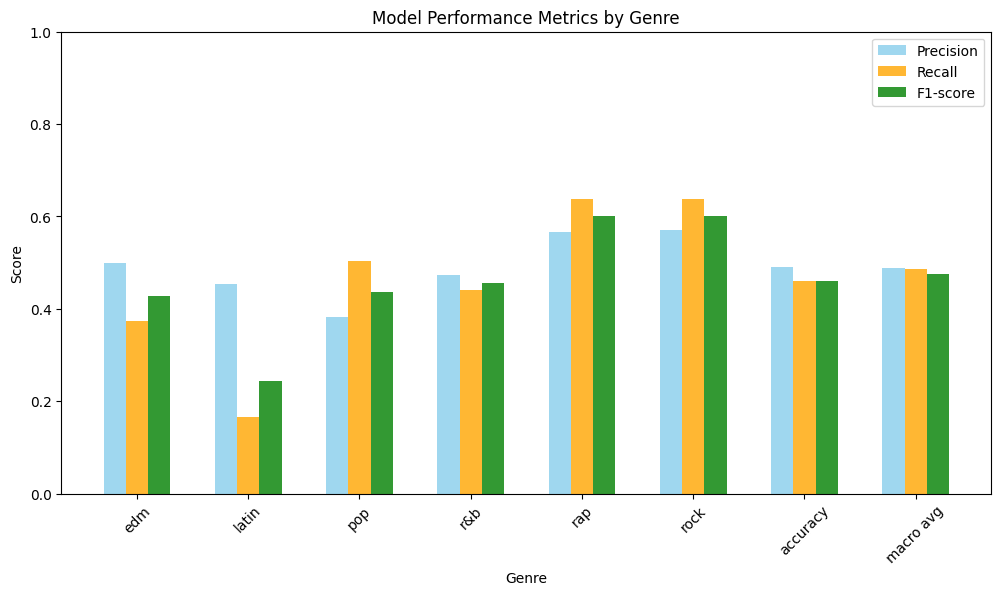

In [51]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Assuming y_true_labels and y_pred_labels are already defined as genre labels

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)

# Get genres and their respective metrics
genres = list(report.keys())
metrics = ['precision', 'recall', 'f1-score']

# Initialize lists to store scores for each metric
precision_scores = []
recall_scores = []
f1_scores = []

# Collect scores for each genre
for genre in genres:
    if genre != 'accuracy':  # Exclude 'accuracy' key
        precision_scores.append(report[genre]['precision'])
        recall_scores.append(report[genre]['recall'])
        f1_scores.append(report[genre]['f1-score'])

# Set width of bars
bar_width = 0.2
index = np.arange(len(genres) - 1)  # Exclude 'accuracy' from x-axis labels

# Plot bars for precision, recall, and f1-score for each genre
plt.figure(figsize=(12, 6))

plt.bar(index, precision_scores, bar_width, label='Precision', color='skyblue', alpha=0.8)
plt.bar(index + bar_width, recall_scores, bar_width, label='Recall', color='orange', alpha=0.8)
plt.bar(index + 2 * bar_width, f1_scores, bar_width, label='F1-score', color='green', alpha=0.8)

# Add labels, title, and legend
plt.xlabel('Genre')
plt.ylabel('Score')
plt.title('Model Performance Metrics by Genre')
plt.xticks(index + bar_width, genres[:-1], rotation=45)  # Set x-axis labels
plt.ylim(0, 1)  # Set y-axis limits for scores
plt.legend()

plt.show()


In [35]:

def preprocess_input(song_features):
    global features
    # Filter the data dictionary to include only the specified features
    filtered_data = {key: song_features[key] for key in features}
    filtered_song_features = pd.DataFrame([filtered_data])
    filtered_song_features.astype(float)
    
    return filtered_song_features


In [36]:
import base64
import requests


def get_spotify_access_token(client_id, client_secret):
    # Encode client ID and client secret in Base64
    client_credentials = f"{client_id}:{client_secret}"
    encoded_credentials = base64.b64encode(client_credentials.encode()).decode()

    # Spotify Accounts service token endpoint
    token_url = "https://accounts.spotify.com/api/token"

    # Request parameters
    payload = {"grant_type": "client_credentials"}

    # Request headers
    headers = {"Authorization": f"Basic {encoded_credentials}"}

    try:
        # Make a POST request to get access token
        response = requests.post(token_url, data=payload, headers=headers)

        # Parse response
        if response.status_code == 200:
            access_token = response.json().get("access_token")
            return access_token
        else:
            print(f"Error: {response.text}")
            return None

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return None


# Set your Spotify API credentials
client_id = "854d2548169b4c5f85b8f31d912a2596"
client_secret = "93c0f985de584a84a06e16425bcc044a"

# Get access token
access_token = get_spotify_access_token(client_id, client_secret)


def get_music_features(track_id: str):
    if access_token:
        headers = {"Authorization": f"Bearer {access_token}"}
        track_features_url = f"https://api.spotify.com/v1/audio-features/{track_id}"

        try:
            response = requests.get(track_features_url, headers=headers)
            if response.status_code == 200:
                track_features = response.json()
                return track_features
            else:
                print(f"Error fetching track features: {response.text}")

        except Exception as e:
            print(f"Error occurred: {str(e)}")

In [37]:
get_music_features("11dFghVXANMlKmJXsNCbNl")

{'danceability': 0.696,
 'energy': 0.905,
 'key': 2,
 'loudness': -2.743,
 'mode': 1,
 'speechiness': 0.103,
 'acousticness': 0.011,
 'instrumentalness': 0.000905,
 'liveness': 0.302,
 'valence': 0.625,
 'tempo': 114.944,
 'type': 'audio_features',
 'id': '11dFghVXANMlKmJXsNCbNl',
 'uri': 'spotify:track:11dFghVXANMlKmJXsNCbNl',
 'track_href': 'https://api.spotify.com/v1/tracks/11dFghVXANMlKmJXsNCbNl',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/11dFghVXANMlKmJXsNCbNl',
 'duration_ms': 207960,
 'time_signature': 4}

In [38]:
song_features = get_music_features("5knuzwU65gJK7IF5yJsuaW")

X_test_audio = preprocess_input(
song_features
)

y_pred_prob = model.predict( X_test_audio)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

print("Predicted Labels:", y_pred_labels)

predicted_genres = label_encoder.inverse_transform(y_pred_labels)

print("Predicted genres: ", predicted_genres)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Predicted Labels: [3]
Predicted genres:  ['r&b']


In [23]:
song_lyrics = """
I love it when you call me señorita
I wish I could pretend I didn't need ya
But every touch is ooh, la-la-la
It's true, la-la-la
Ooh, I should be running
Ooh, you keep me coming for ya
Land in Miami
The air was hot from summer rain
Sweat dripping off me
Before I even knew her name, la-la-la
It felt like ooh, la-la-la
Yeah, no
Sapphire moonlight
We danced for hours in the sand
Tequila sunrise
Her body fit right in my hands, la-la-la
It felt like ooh, la-la-la, yeah
I love it when you call me señorita
I wish I could pretend I didn't need ya
But every touch is ooh, la-la-la
It's true, la-la-la
Ooh, I should be running
Ooh, you know I love it when you call me señorita
I wish it wasn't so damn hard to leave ya
But every touch is ooh, la-la-la
It's true, la-la-la
Ooh, I should be running
Ooh, you keep me coming for ya
Locked in the hotel
There's just some things that never change
You say we're just friends
But friends don't know the way you taste, la-la-la
'Cause you know it's been a long time coming
Don't you let me fall, oh
Ooh, when your lips undress me
Hooked on your tongue
Ooh, love, your kiss is deadly
Don't stop
I love it when you call me señorita
I wish I could pretend I didn't need ya
But every touch is ooh, la-la-la
It's true, la-la-la
Ooh, I should be running
Ooh, you know I love it when you call me señorita
I wish it wasn't so damn hard to leave ya
But every touch is ooh, la-la-la
It's true, la-la-la (true, la-la)
Ooh, I should be running
Ooh, you keep me coming for ya
All along I've been coming for ya (for ya)
And I hope it meant something to ya (ooh)
Call my name, I'll be coming for ya
Coming for ya, coming for ya, coming for ya
For ya
For ya (oh, she loves it when I call)
For ya
Ooh, I should be running
Ooh, you keep me coming for ya"""
song_features = get_music_features("0TK2YIli7K1leLovkQiNik")

X_test_text, X_test_audio = preprocess_input(song_lyrics, song_features, tokenizer, max_len)

y_pred_prob = model.predict([X_test_text, X_test_audio])
y_pred_labels = np.argmax(y_pred_prob, axis=1)

print("Predicted Labels:", y_pred_labels)

predicted_genres = label_encoder.inverse_transform(y_pred_labels)

print("Predicted genres: ",predicted_genres)

NameError: name 'tokenizer' is not defined